In [177]:
import pandas as pd
import pickle
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from haversine import haversine
import folium
from folium import plugins
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import poisson
import statsmodels.api as sm
import matplotlib.pyplot as plt


df_base = pd.read_csv('../kaggle_data/input/train.csv')
weather = pd.read_csv('../kaggle_data/input/weather.csv')
spray = pd.read_csv('../kaggle_data/input/spray.csv')

In [98]:
#Change everything to datetimes:
    
df_base.Date = pd.to_datetime(df_base.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)

In [101]:
def recent_weather(date_range):
    recents = weather[weather.Date.isin(date_range)]
    results = {
        'Tmin': recents.Tmin.min(),
        'Tmin_avg' : recents.Tmin.mean(),
        'Precip': recents.PrecipTotal.apply(precip_fix).sum()/ 2.0,
        'Hottest': recents.Heat.max(),
        'Coolest': recents.Cool.max()    
        }
    return results
twoweeks = pd.Timedelta('14 days')
get_past = lambda x: pd.date_range(x - twoweeks, x)
df_base['priorweeks'] = df_base.Date.apply(get_past)
df_base['recent_weather'] = tdf.priorweeks.apply(recent_weather)
df_base = df_base.dropna(how='any', axis=0)

In [134]:
df_base['Tmin'] = df_base['recent_weather'].apply(lambda x: x['Tmin'])
df_base['Precip'] = pd.to_numeric(df_base['recent_weather'].apply(lambda x: x['Precip']), errors='coerce')
df_base['Hottest'] = pd.to_numeric(df_base['recent_weather'].apply(lambda x: x['Hottest']), errors='coerce')
df_base['Cool'] = pd.to_numeric(df_base['recent_weather'].apply(lambda x: x['Coolest']), errors='coerce')
df_base= df_base.dropna(how='any', axis=0)


df1 = df_base.groupby(['Latitude', 'Longitude','Species', 'Address', 'Date', 'Tmin', 'Hottest', 'Cool'], sort=True,
                 as_index = True)[['NumMosquitos', 'WnvPresent']].sum().reset_index()
df1 = df1.dropna(how='any', axis=0)


In [135]:
import folium
from folium import plugins

In [136]:
df1[df1['Species']=='CULEX PIPIENS'].head()


bounds = (df1.Longitude.min(), df1.Longitude.max())

In [137]:
bounds

(-87.930995, -87.531635)

In [138]:
Chicago = folium.Map()

locations = df1[['Latitude','Longitude', 'NumMosquitos']].as_matrix()
Chicago.add_child(plugins.HeatMap(locations, radius=10, min_opacity = 0.5))
# Chicago.add_child(plugins.MarkerCluster(locations))
# Chicago.add_child(plugins.FastMarkerCluster(locations))
Chicago.fit_bounds([[41.644612, -87.930995], [42.01743, -87.531635]])
Chicago

In [139]:
Chicago.get_bounds()
Chicago.zoom_start

1

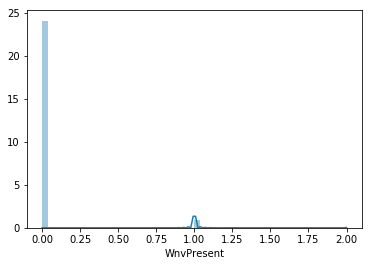

In [140]:
# nonzero = Poisson(tdf['WnvPresent'], tdf[['Latitude', 'Species', 'NumMosquitos']]to

sns.distplot(df1['WnvPresent'])

In [141]:
df1['site'] = LabelEncoder().fit_transform(df1['Address'])
df1.head()

,Latitude,Longitude,Species,Address,Date,Tmin,Hottest,Cool,NumMosquitos,WnvPresent,site
0,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-02,47,7,7,6,0,114
1,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-15,55,0,22,15,0,114
2,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-22,57,0,22,2,0,114
3,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-24,50,8,14,2,0,114
4,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-10-04,57,0,23,2,0,114


In [142]:
train, test = train_test_split(df1, test_size =0.20, random_state=42)

In [143]:
exo = pd.concat([ train['NumMosquitos'],pd.get_dummies(train['Species'], drop_first=True),pd.get_dummies(train['site'], drop_first=True)], axis=1)
exo = sm.add_constant(exo, prepend=False)
endo = train['WnvPresent']
glm_gamma = sm.GLM(endo, exo, family=sm.families.Poisson())
glm_results = glm_gamma.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                 5078
Model:                            GLM   Df Residuals:                     4940
Model Family:                 Poisson   Df Model:                          137
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -642.34
Date:                Wed, 07 Mar 2018   Deviance:                       916.06
Time:                        08:29:53   Pearson chi2:                 3.64e+03
No. Iterations:                    24                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
NumMosquitos               0.0124      0.002      5.982      0.000       0.008       0.017
CULEX PIPIENS/RE

In [144]:
pippi=train[train['Species'].str.contains('PIPIENS')]
pippi2 = test[test['Species'].str.contains('PIPIENS')]
pippi.head()

,Latitude,Longitude,Species,Address,Date,Tmin,Hottest,Cool,NumMosquitos,WnvPresent,site
57,41.659112,-87.538693,CULEX PIPIENS/RESTUANS,"4000 East 130th Street, Chicago, IL 60633, USA",2009-09-25,56,1,15,6,0,53
3593,41.868142,-87.696269,CULEX PIPIENS/RESTUANS,"1100 South California Avenue, Chicago, IL 6061...",2011-07-25,59,1,18,22,0,6
3319,41.857402,-87.694991,CULEX PIPIENS/RESTUANS,"3000 West 18th Street, Chicago, IL 60608, USA",2007-08-01,56,1,15,5,0,39
6305,42.017430,-87.687769,CULEX PIPIENS/RESTUANS,"7500 North Oakley Avenue, Chicago, IL 60645, USA",2007-08-21,45,9,8,2,0,99
292,41.673408,-87.599862,CULEX PIPIENS,"South Doty Avenue, Chicago, IL, USA",2007-08-16,57,0,19,50,0,123


In [145]:
exo = pippi['NumMosquitos']
exo = sm.add_constant(exo, prepend=False)
endo = pippi['WnvPresent']
glm_poisson = sm.GLM(endo, exo, family=sm.families.Poisson())
glm_results = glm_poisson.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                 3721
Model:                            GLM   Df Residuals:                     3719
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -692.58
Date:                Wed, 07 Mar 2018   Deviance:                       1032.5
Time:                        08:29:53   Pearson chi2:                 3.27e+03
No. Iterations:                    10                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
NumMosquitos     0.0133      0.001      9.211      0.000       0.010       0.016
const           -3.3331      0.088    -37.812 

In [146]:
exo = pd.concat([pippi['NumMosquitos'], pd.get_dummies(pippi['site'])], axis=1)
exo = sm.add_constant(exo, prepend=False)
endo = pippi['WnvPresent']
fishy = sm.GLM(endo, exo, family=sm.families.Poisson())
catch = fishy.fit()
print(catch.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                 3721
Model:                            GLM   Df Residuals:                     3589
Model Family:                 Poisson   Df Model:                          131
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -599.96
Date:                Wed, 07 Mar 2018   Deviance:                       847.31
Time:                        08:29:55   Pearson chi2:                 2.40e+03
No. Iterations:                    23                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
NumMosquitos     0.0133      0.002      6.420      0.000       0.009       0.017
0               10.1778   7539.872      0.001 

In [183]:
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.model_selection  import cross_val_score, cross_val_predict
from sklearn import metrics

exo = pippi[['NumMosquitos', 'Tmin', 'Hottest', 'Cool']]
exo = sm.add_constant(exo, prepend=True)
endo = pippi['WnvPresent'].apply(lambda x: 1 if x>0 else 0)
logreg = LogisticRegression()
logreg.fit(exo, endo)

scores = cross_val_score(logreg, exo, endo, cv=5)
print("Cross-validated scores:", scores)



# glm_poisson = sm.GLM(endog=endo, exog=exo, family=sm.families.Poisson())
# logit_results = logit_model.fit()
# print(logit_results.summary())


# exo = pd.concat([pippi['NumMosquitos'], pd.get_dummies(pippi['site'])], axis=1)
# exo = sm.add_constant(exo, prepend=False)
# endo = pippi['WnvPresent']
# fishy = sm.GLM(endo, exo, family=sm.families.Poisson())
# catch = fishy.fit()
# print(catch.summary())

Cross-validated scores: [0.94899329 0.9516129  0.9516129  0.9516129  0.95295699]


In [184]:
exo_test = pippi2[['NumMosquitos', 'Tmin', 'Hottest', 'Cool']]
exo_test = sm.add_constant(exo_test, prepend=True)
endo_test = pippi2['WnvPresent'].apply(lambda x: 1 if x>0 else 0)
exo_test.shape, endo_test.shape


logreg.score(exo_test, endo_test)

0.9517014270032931

In [185]:
from sklearn.model_selection  import cross_val_score, cross_val_predict
from sklearn import metrics

exo = pippi[['Tmin', 'Hottest', 'Cool']]
exo = sm.add_constant(exo, prepend=True)
endo = pippi['NumMosquitos']
fishreg = sm.GLM(endo, exo, family=sm.families.Poisson())
fishy_fit = fishreg.fit()
print(fishreg.fit().summary())

exo_test = pippi[['Tmin', 'Hottest', 'Cool']]
exo_test = sm.add_constant(exo_test, prepend=True)
endo_test = pippi['NumMosquitos']

fish_pred = fishy_fit.predict(exo_test)



                 Generalized Linear Model Regression Results                  
Dep. Variable:           NumMosquitos   No. Observations:                 3721
Model:                            GLM   Df Residuals:                     3717
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -51261.
Date:                Wed, 07 Mar 2018   Deviance:                       88748.
Time:                        08:49:05   Pearson chi2:                 1.27e+05
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4872      0.090     38.620      0.000       3.310       3.664
Tmin          -0.0134      0.002     -8.669      0.0

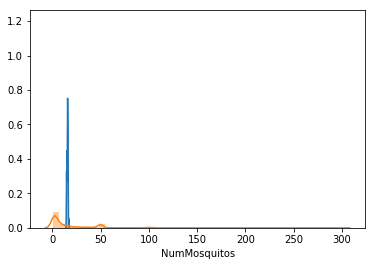

In [186]:
sns.distplot(fish_pred)

sns.distplot(endo_test)